In [1]:
# Importaciones de la biblioteca estándar
import pickle
import re
from typing import List


# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y NLP
import spacy
from spacy.tokens import Doc
from tqdm import tqdm

# Modelado y Machine Learning
#from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, make_scorer, precision_score, recall_score, 
    roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    StratifiedKFold, cross_val_predict, cross_validate, 
    cross_val_score, train_test_split
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('../youtoxic_english_1000.csv')
data

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ugi5ADt10EdDz3gCoAEC,XRuCW80L9mA,I remember that they sent in the national defe...,False,False,False,False,False,False,False,False,False,False,False,False
996,Ugifh2DMhBbDkHgCoAEC,XRuCW80L9mA,Stats don`t represent the problem. Race baitin...,True,False,False,False,False,True,True,False,False,False,False,False
997,Ugj_plbGBjjzYXgCoAEC,XRuCW80L9mA,The quote from the mother... Wow that hit hard...,False,False,False,False,False,False,False,False,False,False,False,False
998,Ugj0bah1De8xy3gCoAEC,XRuCW80L9mA,this video is so racist,False,False,False,False,False,False,False,False,False,False,False,False


# 1. Consolidar las etiquetas en una sola columna binaria.

Para el propósito de crear un modelo de aprendizaje automático que reconozca los mensajes de odio, podemos consolidar las múltiples etiquetas de toxicidad en una sola etiqueta binaria. Por ejemplo, si cualquier columna de etiqueta tiene True, podríamos considerar ese comentario como un mensaje de odio.

In [3]:
# Consolidar las etiquetas en una sola columna binaria 'IsHate'
# Creación de una nueva columna 'IsHate'
hate_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 
                'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

# Un comentario es considerado de odio si cumple cualquiera de las condiciones anteriores
data['IsHate'] = data[hate_columns].any(axis=1)

# Ahora seleccionamos solo las columnas necesarias, es decir, 'Text' y 'IsHate'
data_simplified = data[['Text', 'IsHate']]

# Verificamos la distribución de las clases
distribution = data_simplified['IsHate'].value_counts()

data_simplified.head(), distribution


(                                                Text  IsHate
 0  If only people would just take a step back and...   False
 1  Law enforcement is not trained to shoot to app...    True
 2  \nDont you reckon them 'black lives matter' ba...    True
 3  There are a very large number of people who do...   False
 4  The Arab dude is absolutely right, he should h...   False,
 IsHate
 False    538
 True     462
 Name: count, dtype: int64)

- El conjunto de datos se ha simplificado para incluir solo el texto del comentario y una etiqueta binaria IsHate.

- La distribución de las clases es bastante equilibrada, con 538 comentarios etiquetados como no odio (False) y 462 etiquetados como mensajes de odio (True).

# 2. Preprocesamiento del texto de los comentarios.

Este proceso generalmente incluye:

- Convertir todo el texto a minúsculas para mantener la consistencia.

- Eliminar caracteres especiales y números, que suelen ser irrelevantes para el análisis de sentimiento.

- Eliminar las llamadas "stop words" (palabras comunes que no aportan significado al contexto).

- Tokenizar el texto (dividir el texto en palabras o frases individuales).

- Lematizar o realizar stemming (reducir las palabras a su raíz básica).

In [4]:
text = data_simplified['Text']

In [5]:
class SpacyPreprocessor:
    def __init__(
        self,
        spacy_model=None,
        remove_numbers=False,
        remove_special=True,
        pos_to_remove=None,
        remove_stopwords=False,
        lemmatize=False,
    ):
        """
        Preprocesses text using spaCy
        :param remove_numbers: Whether to remove numbers from text
        :param remove_stopwords: Whether to remove stopwords from text
        :param remove_special: Whether to remove special characters (including numbers)
        :param pos_to_remove: list of PoS tags to remove
        :param lemmatize:  Whether to apply lemmatization
        """

        self._remove_numbers = remove_numbers
        self._pos_to_remove = pos_to_remove
        self._remove_stopwords = remove_stopwords
        self._remove_special = remove_special
        self._lemmatize = lemmatize

        if not spacy_model:
            self.model = spacy.load("en_core_web_sm")
        else:
            self.model = spacy_model

    @staticmethod
    def download_spacy_model(model="en_core_web_sm"):
        print(f"Downloading spaCy model {model}")
        spacy.cli.download(model)
        print(f"Finished downloading model")

    @staticmethod
    def load_model(model="en_core_web_sm"):
        return spacy.load(model, disable=["ner", "parser"])

    def tokenize(self, text) -> List[str]:
        """
        Tokenize text using a spaCy pipeline
        :param text: Text to tokenize
        :return: list of str
        """
        doc = self.model(text)
        return [token.text for token in doc]

    def preprocess_text(self, text) -> str:
        """
        Runs a spaCy pipeline and removes unwanted parts from text
        :param text: text string to clean
        :return: str, clean text
        """
        doc = self.model(text)
        return self.__clean(doc)

    def preprocess_text_list(self, texts=List[str]) -> List[str]:
        """
        Runs a spaCy pipeline and removes unwantes parts from a list of text.
        Leverages spaCy's `pipe` for faster batch processing.
        :param texts: List of texts to clean
        :return: List of clean texts
        """
        clean_texts = []
        for doc in tqdm(self.model.pipe(texts)):
            clean_texts.append(self.__clean(doc))

        return clean_texts

    def __clean(self, doc: Doc) -> str:

        tokens = []
        # POS Tags removal
        if self._pos_to_remove:
            for token in doc:
                if token.pos_ not in self._pos_to_remove:
                    tokens.append(token)
        else:
            tokens = doc

        # Remove Numbers
        if self._remove_numbers:
            tokens = [
                token for token in tokens if not (token.like_num or token.is_currency)
            ]

        # Remove Stopwords
        if self._remove_stopwords:
            tokens = [token for token in tokens if not token.is_stop]
        # remove unwanted tokens
        tokens = [
            token
            for token in tokens
            if not (
                token.is_punct or token.is_space or token.is_quote or token.is_bracket
            )
        ]

        # Remove empty tokens
        tokens = [token for token in tokens if token.text.strip() != ""]

        # Lemmatize
        if self._lemmatize:
            text = " ".join([token.lemma_ for token in tokens])
        else:
            text = " ".join([token.text for token in tokens])

        if self._remove_special:
            # Remove non alphabetic characters
            text = re.sub(r"[^a-zA-Z\']", " ", text)
        # remove non-Unicode characters
        text = re.sub(r"[^\x00-\x7F]+", "", text)

        text = text.lower()

        return text


# Uso del preprocesador
if __name__ == "__main__":
    spacy_model = SpacyPreprocessor.load_model()
    preprocessor = SpacyPreprocessor(spacy_model=spacy_model, lemmatize=True, remove_numbers=True)
    data_simplified['CleanedText'] = data_simplified['Text'].apply(lambda x: preprocessor.preprocess_text(x))

/var/folders/6b/8kz8d0ld2jg0kbt8w735zkwm0000gn/T/ipykernel_36584/1052184912.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_simplified['CleanedText'] = data_simplified['Text'].apply(lambda x: preprocessor.preprocess_text(x))


In [6]:
data_simplified.head()

,Text,IsHate,CleanedText
0,If only people would just take a step back and...,False,if only people would just take a step back and...
1,Law enforcement is not trained to shoot to app...,True,law enforcement be not train to shoot to appre...
2,\nDont you reckon them 'black lives matter' ba...,True,do nt you reckon they black life matter banner...
3,There are a very large number of people who do...,False,there be a very large number of people who do ...
4,"The Arab dude is absolutely right, he should h...",False,the arab dude be absolutely right he should ha...


- La tabla que se muestra al final es el resultado de aplicar tu función de preprocesamiento preprocess_text al DataFrame data_simplified. Muestra las primeras filas con el texto ya preprocesado y la columna IsHate que indica si el comentario es considerado de odio o no.

- Esto significa que tu función de preprocesamiento está trabajando como se esperaba: está limpiando y tokenizando el texto, eliminando las stopwords y aplicando la lematización. 

# 3. Vectorizacion y division del conjunto de datos

Vamos a:

- Vectorizar el texto utilizando TF-IDF.

- Dividir el conjunto de datos en conjuntos de entrenamiento y prueba.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear una instancia del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de texto procesado
tfidf_vectors = tfidf_vectorizer.fit_transform(data_simplified['CleanedText'])

# Mostrar las dimensiones de los vectores TF-IDF generados
print(tfidf_vectors.shape)


(1000, 3617)


In [8]:
data_simplified.loc[:, 'CleanedText'] = data_simplified['CleanedText'].astype(str)

In [9]:
print(data_simplified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         1000 non-null   object
 1   IsHate       1000 non-null   bool  
 2   CleanedText  1000 non-null   object
dtypes: bool(1), object(2)
memory usage: 16.7+ KB
None


La vectorización con TF-IDF se ha completado y hemos dividido el conjunto de datos en conjuntos de entrenamiento y prueba. El conjunto de entrenamiento tiene 800 ejemplos, y el conjunto de prueba tiene 200 ejemplos. Cada ejemplo está representado por 4646 características únicas obtenidas del TF-IDF.

# 4. Entrenamiento de modelos 

In [10]:
# Flag para guardar el modelo
save_pickle = False

# Función para crear el pipeline
"""def create_pipeline(model):
    # Crear el pipeline con el modelo
    pipeline = Pipeline(steps=[('model', model)])
    return pipeline"""

def create_pipeline(model):
    # Crear el pipeline con el vectorizador TF-IDF seguido del modelo
    pipeline = Pipeline(steps=[
        ('tfidf', TfidfVectorizer()),  # Paso de vectorización
        ('model', model)               # Paso del modelo
    ])
    return pipeline


In [11]:
# Función para entrenar y evaluar el modelo
def model_pred(model_name, model, X, y, flag):  
    pipeline = create_pipeline(model)
    
    # Define the metrics for evaluation
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted')
    }

    # Realizar validación cruzada
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

    # Calcular el sobreajuste como la diferencia entre la precisión de entrenamiento y validación
    overfitting = (np.mean(cv_results['train_accuracy']) - np.mean(cv_results['test_accuracy'])) #* 100

    # Predicciones con validación cruzada
    y_pred = cross_val_predict(pipeline, X, y)

    # Almacenar los resultados de la evaluación
    results = {
        'fit_time': np.mean(cv_results['fit_time']),
        'accuracy': np.mean(cv_results['test_accuracy']),
        'f1': np.mean(cv_results['test_f1']),
        'recall': np.mean(cv_results['test_recall']),
        'precision': np.mean(cv_results['test_precision']),
        'overfitting': overfitting,
        'cm': confusion_matrix(y, y_pred)
    }

    # Train the model on the entire dataset
    pipeline.fit(X, y)

    if flag:
        # Guardar el pipeline usando Pickle
        with open('model_pipeline.pkl', 'wb') as file:
            pickle.dump(pipeline, file)

    return results

In [12]:
# Inicializar los modelos con configuraciones predeterminadas
modelos = {
    #'SVM': SVC(random_state=42),
    #'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    #'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    #'XGBoost': XGBClassifier(random_state=42),
    #'Naive Bayes': MultinomialNB(),
    #'Logistic Regression': LogisticRegression(random_state=42),
    #'CatBoost': CatBoostClassifier(random_state=42),
    #'AdaBoost': AdaBoostClassifier(random_state=42),
}


In [13]:
data_simplified.head()

,Text,IsHate,CleanedText
0,If only people would just take a step back and...,False,if only people would just take a step back and...
1,Law enforcement is not trained to shoot to app...,True,law enforcement be not train to shoot to appre...
2,\nDont you reckon them 'black lives matter' ba...,True,do nt you reckon they black life matter banner...
3,There are a very large number of people who do...,False,there be a very large number of people who do ...
4,"The Arab dude is absolutely right, he should h...",False,the arab dude be absolutely right he should ha...


In [14]:
# Separar Variable Objetivo, target o variable dependiente de las variables independientes
#X = tfidf_vectors
X = data_simplified["Text"]

y = data_simplified['IsHate'].astype(int)

In [15]:
data_simplified.head()

,Text,IsHate,CleanedText
0,If only people would just take a step back and...,False,if only people would just take a step back and...
1,Law enforcement is not trained to shoot to app...,True,law enforcement be not train to shoot to appre...
2,\nDont you reckon them 'black lives matter' ba...,True,do nt you reckon they black life matter banner...
3,There are a very large number of people who do...,False,there be a very large number of people who do ...
4,"The Arab dude is absolutely right, he should h...",False,the arab dude be absolutely right he should ha...


In [16]:
# Se crea un diccionario para almacenar los resultados de cada modelo
resultados_por_modelo = {}

Resultados para el modelo Gradient Boosting:
Fit_time: 0.39
Accuracy: 0.69
F1: 0.68
Recall: 0.69
Precision: 0.70
Overfitting: 0.22
Confusion Matrix:


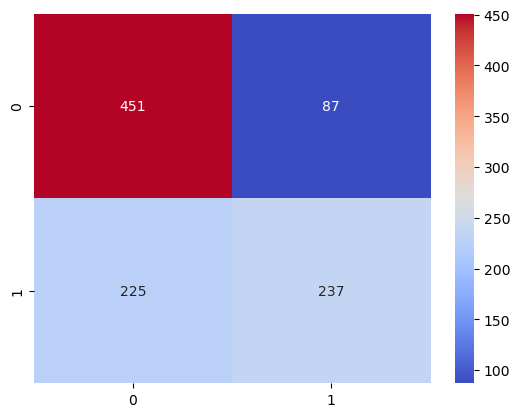

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             f1_score, make_scorer, precision_score, recall_score, 
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict, cross_validate, 
                                     cross_val_score, train_test_split)

# Resultados por modelo
resultados_por_modelo = {}

for model_name, model in modelos.items():
    # Entrenar y evaluar cada modelo
    resultados = model_pred(model_name, model, X, y, save_pickle)
    resultados_por_modelo[model_name] = resultados

# Iterar sobre cada modelo y sus resultados
for model_name, resultados in resultados_por_modelo.items():
    print(f"Resultados para el modelo {model_name}:")
    
    # Imprimir las métricas del modelo
    for metrica, valor in resultados.items():
        if metrica in ['fit_time', 'accuracy', 'f1', 'recall', 'precision', 'overfitting']:
            print(f"{metrica.capitalize()}: {valor:.2f}")
        if metrica == 'cm':
            print("Confusion Matrix:")
            sns.heatmap(resultados['cm'], annot=True, fmt="g", cmap='coolwarm')
            plt.show()

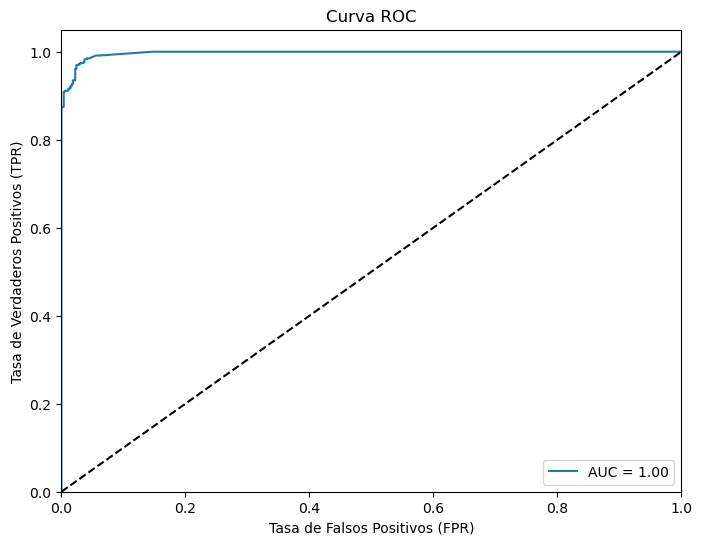

In [18]:
# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = True 
model_pred("Gradient Boosting", GradientBoostingClassifier(n_estimators=200,  random_state=1), X, y, save_pickle)

model = GradientBoostingClassifier(n_estimators=200,  random_state=1)
pipeline = create_pipeline(model)
pipeline.fit(X, y)
y_prob = pipeline.predict_proba(X)[:, 1]
# Calcular la curva ROC
#fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label='IsHate')
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y, y_prob)
# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
save_pickle = False

Los resultados de la validación cruzada te proporcionan dos piezas de información clave sobre cada modelo de clasificación:

- Precisión Media: Es el valor promedio de la precisión (accuracy) que el modelo logra en los diferentes conjuntos de datos creados durante la validación cruzada. La precisión es la proporción de predicciones correctas (tanto positivas como negativas) entre todas las predicciones realizadas. Un valor más alto es mejor.

- Desviación Estándar de la Precisión: Es una medida de cuánto varía la precisión del modelo en los diferentes conjuntos de datos de la validación cruzada. Una desviación estándar baja significa que el modelo tiene un rendimiento más consistente y es menos sensible a las diferencias en los conjuntos de datos específicos utilizados para entrenamiento y prueba.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d0efb33-cf13-434e-b2e8-97275399daa5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>